# **Introduction & Motivation**

This project aims to develop a machine learning model that accurately classifies product reviews as spam or not spam, addressing a critical challenge in e-commerce. Spam reviews significantly harm consumer trust and the credibility of online platforms. By leveraging a rich dataset of Amazon product reviews, including numerical, categorical, and textual features, the project will focus on data preprocessing, feature engineering, and model training to create a reliable spam detection system. The ultimate goal is to enhance the authenticity of reviews, improve user experience, and support businesses in maintaining a trustworthy reputation.


In [ ]:
# General imports
import pandas as pd
import numpy as np
import math
import regex as re
import string
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict

# NLTK imports
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import textstat

# Sklearn imports
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils import resample
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from mlxtend.classifier import EnsembleVoteClassifier
import copy



# Gensim and Word2Vec imports
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader as api
import word2vec as wv

# Sentence Transformers
from sentence_transformers import SentenceTransformer

# Scipy imports
from scipy.sparse import hstack

# Pickle for saving/loading models
import pickle

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


# Warnings
warnings.filterwarnings('default')
vader = SentimentIntensityAnalyzer()

# Download NLTK resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/divyamrana/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/divyamrana/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/divyamrana/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/divyamrana/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/divyamrana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/divyamrana/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# **Loading and Initial Data Preprocessing**

### Reading the dataframe

In [ ]:
#Initial Dataset
datum = pd.read_json('Clothing_Shoes_and_Jewelry.json', lines = True)

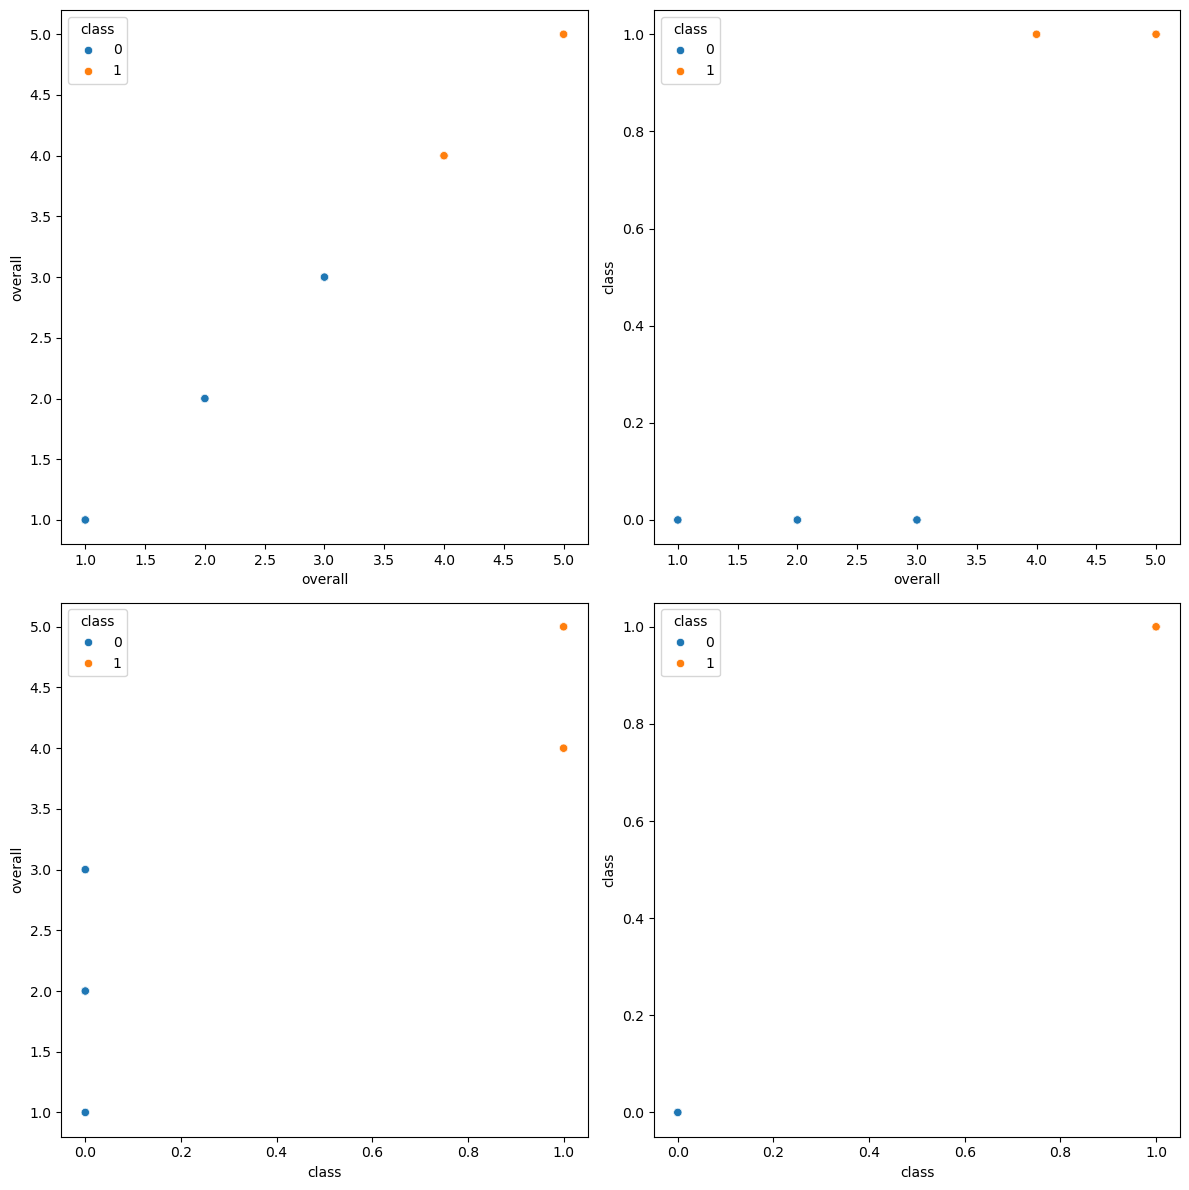

In [ ]:
selected_columns = ['overall', 'class']
df_filtered = datum[selected_columns]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

sns.scatterplot(ax=axes[0, 0], data=datum, x='overall', y='overall', hue='class')
sns.scatterplot(ax=axes[0, 1], data=datum, x='overall', y='class', hue='class')
sns.scatterplot(ax=axes[1, 0], data=datum, x='class', y='overall', hue='class')
sns.scatterplot(ax=axes[1, 1], data=datum, x='class', y='class', hue='class')

plt.tight_layout()
plt.show()

1. **Subplots Explanation**:
   - **Top Left (axes[0, 0]):**
     - X-axis: `'overall'`
     - Y-axis: `'overall'`
     - This plot shows points where both axes are the same (`'overall'`), forming a diagonal pattern as expected. The hue (`'class'`) highlights how the two classes are distributed along this diagonal.

   - **Top Right (axes[0, 1]):**
     - X-axis: `'overall'`
     - Y-axis: `'class'`
     - This plot shows how the `'overall'` scores are distributed across the two classes.
     - It reveals whether one class tends to have higher or lower `'overall'` scores.

   - **Bottom Left (axes[1, 0]):**
     - X-axis: `'class'`
     - Y-axis: `'overall'`
     - Similar to the top-right plot but flipped, showing how the `'overall'` values vary for each class category (`0` or `1`).

   - **Bottom Right (axes[1, 1]):**
     - X-axis: `'class'`
     - Y-axis: `'class'`
     - This plot shows points where both axes are `'class'`, resulting in two distinct points for class `0` and class `1`.

2. **General Observations**:
   - The `hue='class'` ensures the data points are color-coded based on their class, making it easier to visually distinguish between the two groups (`0` and `1`).
   - The top-right and bottom-left plots provide insight into how the two variables (`'overall'` and `'class'`) relate to each other and whether any trends or separations exist between the classes.

3. **Insights from the Plots**:
   - The **diagonal pattern** in the top-left plot confirms that `'overall'` values align with themselves as expected.
   - In the **top-right plot**, if one class is consistently higher or lower on `'overall'`, it suggests class separation based on this feature.
   - The **bottom-left plot** complements this by showing the reverse relationship, helping to cross-check the distribution.
   - The **bottom-right plot** simply visualizes the binary nature of the `'class'` variable.

4. **Conclusion**:
   - These scatter plots are useful for understanding the relationship between `'overall'` and `'class'` as well as how the two classes are distributed in the dataset.
   - Further statistical or modeling work might explore whether `'overall'` can effectively distinguish between the two classes (`0` and `1`).


In [ ]:
#drop columns - category, overall
# Dropping overall as it is a direct predictor of the variable - class (spam / non-spam)
data_first_cleanup = datum.drop(columns=['category', 'overall', 'unixReviewTime', 'reviewTime', 'summary', 'reviewerID', '_id'])

## Shortening the dataframe

In [ ]:
# Shortening Dataset
num_reviews = (data_first_cleanup['asin'].value_counts()).sort_values(ascending=False)
pids = set(num_reviews[:5000].index)
df = data_first_cleanup[data_first_cleanup['asin'].isin(pids)]
#df.to_parquet('final_usage.parquet', compression='snappy')

In [ ]:
#df = pd.read_parquet('final_usage.parquet')
df['spam_not_spam'] = df['class']
df.drop(columns = 'class', inplace=True)

/var/folders/nm/pb4pcvl954j110mq4qv7wj080000gn/T/ipykernel_93018/3965866888.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['spam_not_spam'] = df['class']
/var/folders/nm/pb4pcvl954j110mq4qv7wj080000gn/T/ipykernel_93018/3965866888.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns = 'class', inplace=True)


Checking for missing values and data types.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


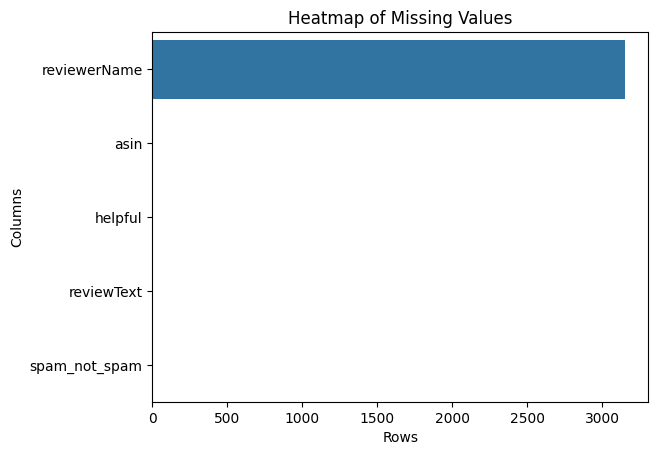

In [ ]:
missing_values = df.isna().sum().sort_values(ascending=False)

# Plot the heatmap of missing values
sns.barplot(x = missing_values.values, y = missing_values.index)
plt.title("Heatmap of Missing Values")
plt.xlabel("Rows")
plt.ylabel("Columns")
plt.show()


In [ ]:
#Dropping null values
df = df.dropna()

**Result Interpretation**:
- **`reviewerName`**: Contains over 3000 missing values, suggesting that further preprocessing (e.g., imputation or removal) is needed for this column.
- Other columns (`asin`, `helpful`, `reviewText`, `class`) have few or no missing values.
- These insights help inform strategies for handling missing data and improving dataset quality.

## Downsampling

In [ ]:
# Downsampling
# Separate majority and minority classes
df_majority = df[df['spam_not_spam'] == 1]
df_minority = df[df['spam_not_spam'] == 0]

# Downsample majority class
df_majority_downsampled = resample(df_majority,
                                 replace=False,
                                 n_samples=len(df_minority),
                                 random_state=42)
df = pd.concat([df_majority_downsampled, df_minority])


In [ ]:
df = df.reset_index(drop = True)
df

,asin,reviewerName,helpful,reviewText,spam_not_spam
0,B001U2T3HI,ohalice,"[0, 0]",Exactly as described and came very quickly. It...,1
1,B00550PLV8,JenAT,"[0, 0]","This is a great bra. It's so comfortable, you'...",1
2,B0015TYXQW,Zombie slayer.,"[0, 0]",Very comfortable shoe. Easy to slip on quickl...,1
3,B000067R84,Karrie Y. Piletic,"[4, 4]",My 3 year old loves this little backpack. She ...,1
4,B008H2ET0U,Anne Snyder,"[0, 0]",I bought several packages for our Angel Tree a...,1
...,...,...,...,...,...
451523,B00JHZSVYG,Ronnee Legington,"[0, 0]",I was so excited to receive this item but quic...,0
451524,B00JHZSVYG,Sonia,"[0, 0]",I received the bathing suit but there is a def...,0
451525,B00JHZSVYG,The rose center,"[1, 2]",The top ties around the neck and back so it is...,0
451526,B00JHZSVYG,Timah,"[0, 1]",I wish there were zero stars. This product is ...,0


This code addresses the **class imbalance** problem by downsampling the majority class (`class == 1`) to match the size of the minority class (`class == 0`).

1. **Separating Majority and Minority Classes**:
   - `df_majority`: Contains majority class data with `class == 1`.
   - `df_minority`: Contains minority class data with `class == 0`.

2. **Downsampling the Majority Class**:
   - The `resample` function is used to reduce the size of the majority class to match the minority class.
   - `replace=False`: Ensures no duplicate samples are selected.
   - `n_samples=len(df_minority)`: Matches the number of samples in the minority class.
   - `random_state=42`: Ensures reproducibility of results.

3. **Combining the Data**:
   - The downsampled majority class and the minority class are combined to create a new, balanced dataset.

**Result**:
This code ensures that the sample sizes of both classes are balanced, mitigating the class imbalance issue during model training. This leads to a more fair learning process and improves the model's predictive performance for the minority class.

In [ ]:
relative_frequencies = df['spam_not_spam'].value_counts() / df.shape[0]

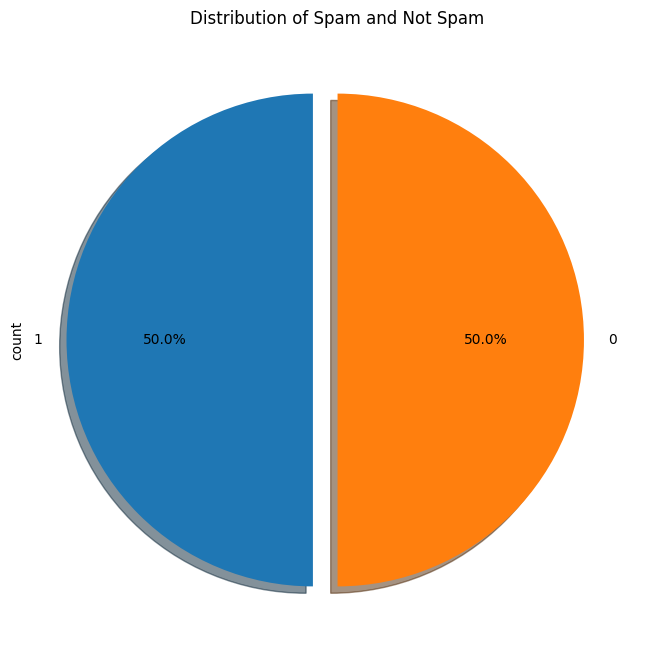

In [ ]:
plt.figure(figsize=(8, 8))
relative_frequencies.plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    labels=relative_frequencies.index,
    explode=[0.1 if i == relative_frequencies.idxmax() else 0 for i in relative_frequencies.index],
    shadow=True
)
plt.title("Distribution of Spam and Not Spam")
plt.show()

The pie chart visualizes the relative frequency distribution of the `spam_not_spam` column in the dataset, representing two classes: spam and not spam.

- The blue section represents spam (`1`), while the orange section represents not spam (`0`).
- The data is **evenly distributed** with exactly **50.0%** for each class.
- This chart highlights that the dataset is balanced, making it suitable for analysis or machine learning tasks involving classification.

# **Text Data Preprocessing and Feature Engineering**

## Creating Embedding Matrix for Faster Processing

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')
reviews_matrix = defaultdict(list)
df_emb_1 = df[df['spam_not_spam'] == 1]
grouped = df_emb_1.groupby('asin')

# Process each group
for asin, group in tqdm(grouped):
    smaller = group.reset_index()
    if smaller.shape[0] > 0:
        # Filter for non-empty reviewText and batch encode
        review_texts = [x for x in smaller['reviewText'].iloc[:100] if isinstance(x, str) and len(x) > 0]
        if review_texts:  # Ensure there are valid texts
            embs = model.encode(review_texts, show_progress_bar=False)
            # Store the mean of embeddings for this ASIN
            reviews_matrix[asin] = np.mean(embs, axis=0)

with open('Final File/reviews_matrix.pkl', 'wb') as f:
    pickle.dump(reviews_matrix, f)

print("Reviews matrix saved to 'reviews_matrix.pkl'")

100%|██████████| 4998/4998 [37:12<00:00,  2.24it/s]


Reviews matrix saved to 'reviews_matrix.pkl'


This code generates an **Embedding Matrix** by converting review text into embedding vectors.

1. **Initialize SentenceTransformer Model**:
   - The `SentenceTransformer('all-MiniLM-L6-v2')` model is used to convert textual data into embedding vectors.

2. **Filter Reviews with Class = 1**:
   - Filters spam reviews (`class == 1`) and groups the data by `asin` (product ID).

3. **Generate Embeddings for Each Group**:
   - For each `asin` group:
     - Select up to 100 review texts (`iloc[:100]`) and filter out empty texts.
     - Use `SentenceTransformer` to encode the review texts into embedding vectors.
     - Compute the mean embedding vector for the group and store it.

4. **Save Embedding Matrix**:
   - Saves the embedding matrix into a `pickle` file (`reviews_matrix.pkl`).
   - The saved file can be used for further analysis or model training.

## Class Implementation

**Reason for Class Implementation**

This code modularizes data preprocessing and feature generation tasks into individual classes, providing the following benefits:  

- **Reusability**: Can be reused across multiple projects or datasets.  
- **Readability**: Each class has a specific role, making the code more understandable.  
- **Scalability**: Easy to add or modify functionalities.  
- **Integration**: Seamlessly integrates with Scikit-learn's `Pipeline`.

In [ ]:
class Cleanup(BaseEstimator, TransformerMixin):

    def remove_emojis(self, data):
        emoj = re.compile("["
            u"\U0001F600-\U0001F64F"
            u"\U0001F300-\U0001F5FF"
            u"\U0001F680-\U0001F6FF"
            u"\U0001F1E0-\U0001F1FF"
            u"\U00002500-\U00002BEF"
            u"\U00002702-\U000027B0"
            u"\U000024C2-\U0001F251"
            u"\U0001f926-\U0001f937"
            u"\U00010000-\U0010ffff"
            u"\u2640-\u2642"
            u"\u2600-\u2B55"
            u"\u200d"
            u"\u23cf"
            u"\u23e9"
            u"\u231a"
            u"\ufe0f"
            u"\u3030"
                        "]+", re.UNICODE)
        return re.sub(emoj, '', data)

    def text_cleaner_stemmer(self, text):
        stop_words = set(stopwords.words('english'))
        final_text = ''
        stem = PorterStemmer()

        #Removing emojis
        removed_emojis = self.remove_emojis(text)

        #Removing stop words
        split_text = list(str.split(removed_emojis))

        cleaned_stop_words = []
        for word in split_text:
            if word.lower() in set(stop_words):
                continue
            cleaned_stop_words.append(stem.stem(word.lower()))

        text_compiled = ' '.join(cleaned_stop_words)

        #Remove punctuation and numbers
        for char in text_compiled:
            if char in set(string.punctuation) or char.isnumeric():
                continue
            final_text += char

        return final_text, list(str.split(final_text))

    def fit(self, X, y=None):
        return self

    def transform(self, X, y = None):
        cleaned_text = []
        split_words = []
        print("Adding cleanup")
        for review in tqdm(X['reviewText']):
            res1, res2 = self.text_cleaner_stemmer(review)
            cleaned_text += [res1]
            split_words += [res2]

        # Apply the optimized function
        X['cleaned_text'] = cleaned_text
        X['word_tokens'] = split_words
        return X

class Similarity(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
        self.model = SentenceTransformer('all-MiniLM-L6-v2')

    def fit(self, X, y = None):
        return self

    def transform(self, X, y=None):
        print('Adding Similarity Score')
        with open('Final File/reviews_matrix.pkl', 'rb') as f:
            reviews_matrix = pickle.load(f)
        batch_size = 10_000
        embeddings = []

        # Process text in batches
        for i in tqdm(range(0, len(X['cleaned_text']), batch_size)):
            batch = X['cleaned_text'][i:i + batch_size].tolist()
            batch_embeddings = self.model.encode(batch)
            embeddings.extend(batch_embeddings)
        similarity = []

        for asin, embedding in tqdm(zip(X['asin'], embeddings)):
            try:
                asin_embedding = np.array(reviews_matrix[asin]).reshape(1, -1)
                review_embedding = np.array(embedding).reshape(1, -1)
                sim = cosine_similarity(asin_embedding, review_embedding)[0][0]
                similarity.append(sim)
            except:
                similarity.append(0)

        X['similarity_'] = np.array(similarity)
        return X

class POS_tagger(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
        self.analyzer = SentimentIntensityAnalyzer()

    def fit(self, X, y = None):
        return self

    def count_features_optimized(self,text):
    # Tokenize text
        words = word_tokenize(text)

        # Part-of-Speech tagging and counts
        pos_counts = {"nouns": 0, "adjectives": 0, "adverbs": 0, "negative_words": 0}
        for word, tag in pos_tag(words):
            if tag.startswith('NN'):
                pos_counts["nouns"] += 1
            elif tag.startswith('JJ'):
                pos_counts["adjectives"] += 1
            elif tag.startswith('RB'):
                pos_counts["adverbs"] += 1

            # Check for negative sentiment
            if self.analyzer.polarity_scores(word)['neg'] > 0:
                pos_counts["negative_words"] += 1

        return pos_counts["nouns"], pos_counts["adjectives"], pos_counts["adverbs"], pos_counts["negative_words"]

    def transform(self, X, y = None):
        nouns, adj, adv, neg_words = [], [], [], []
        print("Adding POS")
        for review in tqdm(X['reviewText']):
            a,b,c,d = self.count_features_optimized(review)
            nouns.append(a)
            adj.append(b)
            adv.append(c)
            neg_words.append(d)
        X['nouns_'] = nouns
        X['adjectives_'] = adj
        X['adverbs_'] = adv
        X['negative_words_'] = neg_words
        return X

class Helpfulness(BaseEstimator, TransformerMixin):
    def fit(self, X, y = None):
        return self

    def transform(self, X, y=None):
        # Splittitng helpfulness
        X['helpful_0'] = np.array([x[0] for x in tqdm(X['helpful'])])
        X['helpful_1']= np.array([x[1] for x in tqdm(X['helpful'])])
        X.drop(columns = ['helpful'], inplace = True)
        return X

### 1. Cleanup Class
**Explanation**  
- `remove_emojis`:  
  This method removes emojis and special characters from the text using regular expressions (regex). It detects a wide range of emojis, such as emoticons, symbols, flags, and more, and eliminates them to make the text cleaner and more suitable for analysis.  
- `text_cleaner_stemmer`:  
  1. Removes emojis from the text and converts all words to lowercase.  
  2. Removes unimportant words based on NLTK's stopword list.  
  3. Uses Porter Stemmer to extract word stems (e.g., "running" → "run"), ensuring consistent representation of words.  
  4. Removes punctuation and numbers from the text, returning the cleaned text and a list of tokens.

**Reason**
By modularizing text cleaning, the data preprocessing process becomes simpler and more reusable. This ensures consistent text processing across the pipeline.

### 2. Similarity Class
**Explanation**  
- This class generates semantic embeddings for review text and compares them with product embeddings to calculate similarity.  
  1. Uses the `SentenceTransformer` model (`all-MiniLM-L6-v2`) to convert review text into vectors.  
  2. Processes vectors in batches to enhance efficiency and avoid memory issues.  
  3. Computes cosine similarity between product (`asin`) embeddings and review embeddings, storing results in the `similarity_` column.  
  4. Assigns a similarity score of 0 for cases where embedding information is unavailable.

**Reason**  
By implementing similarity computation in a class, scalability and maintainability are improved. This is critical for NLP tasks that require text similarity analysis.

#### What is Cosine Similarity?
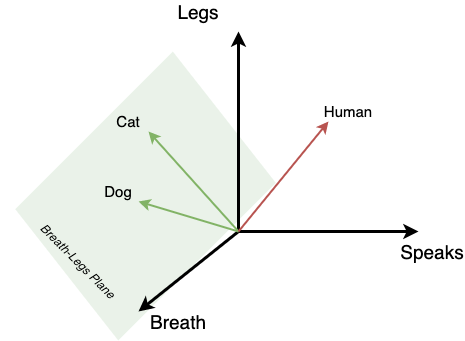

In text analysis, cosine similarity is frequently used to measure the **semantic similarity** between sentences, words, or documents. Using the image as a reference applied to text data:

1. **Vector Representation**:
   - Text data is converted into vectors using an embedding model (e.g., SentenceTransformer).
   - For instance, the `Cat` and `Dog` vectors represent two sentences or words numerically.

2. **Semantic Space of Vectors**:
   - The "Breath-Legs Plane" represents the feature space of text data (semantic dimensions of words).
   - The direction of a vector corresponds to the **semantic position** of a word or sentence, with similar texts having similar directions.

3. **Role of Cosine Similarity**:
   - Measures the **similarity** between two pieces of text (e.g., "Cats are cute" vs. "Dogs are lovable") by computing the **angle** between their vectors:
     - A similarity close to 1 indicates semantic similarity.
     - A similarity close to 0 indicates weak or no relation.
     - A similarity close to -1 indicates opposite meanings.

### 3. POS_tagger Class
**Explanation**  
- Extracts the following information from review text using Part-of-Speech (POS) tagging:  
  1. `nouns`: Counts the number of nouns (words starting with NN tags).  
  2. `adjectives`: Counts the number of adjectives (words starting with JJ tags).  
  3. `adverbs`: Counts the number of adverbs (words starting with RB tags).  
  4. `negative_words`: Uses sentiment analysis to count the number of negative words.  
- This helps in understanding the grammatical structure and emotional tendencies in the text.

**Reason**
POS tagging provides grammatical insights into the text, which can enhance model performance. Modularizing it in a class makes it easier to integrate into the preprocessing pipeline.


### 4. Helpfulness Class
**Explanation**  
- Splits the `helpful` column in Amazon reviews into two separate features:  
  1. `helpful_0`: The number of votes marking the review as "helpful."  
  2. `helpful_1`: The total number of votes received by the review.  
- The original `helpful` column is dropped afterward.

**Reason**  
By clearly defining data transformation steps in the pipeline, this class simplifies additional preprocessing.


In [ ]:
# Custom Class Transformer to get the sentiment score
class VaderSentimentTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y = None):
        return self

    def transform(self, X, y=None):
        print('Adding Sentiment Score')
        X['sentiment_'] = np.array([vader.polarity_scores(text)['compound'] for text in tqdm(X['reviewText'])])
        return X

# Custom Class Transformer to get Flesch Score
class FleschScore(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Perform arbitary transformation
        print('Adding Flesch Score')
        X["flesch_"] = np.array([textstat.flesch_reading_ease(text) for text in tqdm(X['reviewText'])])
        return X

# Custom Class Transformer to get the legnth of the review
class Length_Review(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        print("Adding Length of Review")
        X["review_length_"] = np.array([len(text.split()) for text in tqdm(X['reviewText'])]).reshape(-1,1)
        return X

# Custom Class Transformer to get the number of unique words
class unique_words(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        print('Adding Uniqueness Count')
        X["uniqueness_"] = np.array([len(np.unique(text.split())) for text in tqdm(X['reviewText'])])
        return X



### 5. VaderSentimentTransformer Class
**Explanation**  
- Uses the Vader Sentiment Analyzer to calculate sentiment scores for review text.  
- Results range from -1 (highly negative) to +1 (highly positive) and are stored in the `sentiment_` column.

**Reason**   
Sentiment analysis plays a key role in understanding the context of review data. Separating it into a class allows it to be used independently.

### 6. FleschScore Class
**Explanation**  
- Computes the Flesch Reading Ease score using the `textstat` library.  
- The score indicates how easy the text is to read and is stored in the `flesch_` column.

**Reason**  
Analyzing text complexity provides additional insights useful for modeling.

### 7. Length_Review Class
**Explanation**  
- Counts the number of words in each review and stores the result in the `review_length_` column.

**Reason**    
Review length is a valuable metadata feature that can indicate review quality or reliability.

### 8. unique_words Class
**Explanation**  
- Counts the number of unique words in each review and stores the result in the `uniqueness_` column.

**Reason**
This serves as a metric for measuring review diversity, providing additional richness to the model.

# **Data Preprocessing Pipeline**

In [ ]:
X = df.drop(columns=['spam_not_spam'])
y = df['spam_not_spam']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

- Sets the `spam_not_spam` column as the target variable and the remaining columns as independent variables (`X`).  
- `X` contains the feature data for model training, and `y` represents the target variable indicating spam or not.
- Splits the data into 70% training data and 30% testing data.  
- The `random_state=42` ensures that the data split is reproducible.


In [ ]:
num_cols = ['helpful_0', 'helpful_1', 'nouns_', 'adjectives_', 'adverbs_', 'negative_words_', 'sentiment_', "flesch_", "review_length_", "uniqueness_"]
cols_to_keep = ['similarity_']
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), num_cols),
        ('tfidf', TfidfVectorizer(max_features=2_000), 'cleaned_text'),
        ('passthru', 'passthrough', cols_to_keep)
    ],
    remainder='drop'
)

pipe = Pipeline([
    ('cleanup', Cleanup()),
    ('pos', POS_tagger()),
    ('flesch', FleschScore()),
    ('length', Length_Review()),
    ('vader', VaderSentimentTransformer()),
    ('uniqueness', unique_words()),
    ('similarity', Similarity()),
    ('helpfulness', Helpfulness()),
    ('preprocessor', preprocessor)
])

(pipe)

Pipeline(steps=[('cleanup', Cleanup()), ('pos', POS_tagger()),
                ('flesch', FleschScore()), ('length', Length_Review()),
                ('vader', VaderSentimentTransformer()),
                ('uniqueness', unique_words()), ('similarity', Similarity()),
                ('helpfulness', Helpfulness()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['helpful_0', 'helpful_1',
                                                   'nouns_', 'adjectives_',
                                                   'adverbs_',
                                                   'negative_words_',
                                                   'sentiment_', 'flesch_',
                                                   'review_length_',
                                                   'uniqueness_']),
                                                 ('tfidf',
                                                  TfidfVectorizer(max_features=2000),
                                                  'cleaned_text'),
                                                 ('passthru', 'passthrough',
                                                  ['similarity_'])]))])

#### Preprocessing Setup
- `num_cols`: List of numerical variables to be standardized using `StandardScaler`.  
- `cols_to_keep`: List of variables to be retained as-is, including the `similarity_` column.  
- `preprocessor`:  
  1. `scaler`: Standardizes the numerical variables (`num_cols`).  
  2. `tfidf`: Vectorizes the `cleaned_text` column into a maximum of 2,000 features (Taken due to memory contraints).
  3. `passthru`: Retains the `similarity_` column without modification.  
  4. `remainder='drop'`: Drops all unspecified columns.

#### Pipeline Setup
- Defines a pipeline for sequential data processing:  
1. `Cleanup`: Performs text cleaning (removes emojis, stopwords, and applies stemming).  
2. `POS_tagger`: Conducts POS tagging and computes counts for nouns, adjectives, adverbs, and negative words.  
3. `FleschScore`: Calculates the reading ease score.  
4. `Length_Review`: Computes the number of words in the review.  
5. `VaderSentimentTransformer`: Calculates sentiment scores for the reviews.  
6. `unique_words`: Counts the number of unique words in each review.  
7. `Similarity`: Computes similarity scores between reviews and product embeddings.  
8. `Helpfulness`: Splits the `helpful` column into helpful votes and total votes.  
9. `preprocessor`: Applies the transformations defined in the preprocessing step.


In [ ]:
# Datasets
X_train = pipe.fit_transform(X_train)
X_test = pipe.transform(X_test)

Adding cleanup


100%|██████████| 316069/316069 [02:14<00:00, 2351.98it/s]


Adding POS


100%|██████████| 316069/316069 [08:45<00:00, 601.02it/s]


Adding Flesch Score


100%|██████████| 316069/316069 [00:17<00:00, 18293.29it/s]


Adding Length of Review


100%|██████████| 316069/316069 [00:00<00:00, 448285.45it/s]


Adding Sentiment Score


100%|██████████| 316069/316069 [01:22<00:00, 3827.83it/s]


Adding Uniqueness Count


100%|██████████| 316069/316069 [00:04<00:00, 63910.68it/s]


Adding Similarity Score


100%|██████████| 32/32 [04:12<00:00,  7.88s/it]
316069it [00:46, 6764.53it/s]
100%|██████████| 316069/316069 [00:00<00:00, 2411817.89it/s]


Adding cleanup


100%|██████████| 135459/135459 [00:59<00:00, 2276.33it/s]


Adding POS


100%|██████████| 135459/135459 [03:51<00:00, 584.70it/s]


Adding Flesch Score


100%|██████████| 135459/135459 [00:09<00:00, 14981.26it/s]


Adding Length of Review


100%|██████████| 135459/135459 [00:00<00:00, 442322.54it/s]


Adding Sentiment Score


100%|██████████| 135459/135459 [00:35<00:00, 3847.34it/s]


Adding Uniqueness Count


100%|██████████| 135459/135459 [00:01<00:00, 68772.71it/s]


Adding Similarity Score


100%|██████████| 14/14 [01:41<00:00,  7.25s/it]
135459it [00:20, 6618.98it/s]
100%|██████████| 135459/135459 [00:00<00:00, 2090315.91it/s]


In [ ]:
# Function to get the feature names
def get_feature_names(pipe):
    preprocessor = pipe.named_steps['preprocessor']
    feature_names = []

    for name, transformer, cols in preprocessor.transformers_:
        if name == 'scaler':
            feature_names.extend(cols)
        elif name == 'tfidf':
            feature_names.extend(transformer.get_feature_names_out())
        elif name == 'passthru':
            feature_names.extend(cols)

    return feature_names

feature_names = get_feature_names(pipe)


- This function is used to **extract all feature names generated** in the `preprocessor` step of a pipeline.
- It consolidates feature names from numerical, textual, and passthrough variables into a single list.

# **Modeling**

## Halving Grid Search and Randomized Search

In [ ]:
# Functions for batching
def batch_halving_search(search_model, X, y, batch_size):
    num_samples = X.shape[0]
    for start in tqdm(range(0, num_samples, batch_size)):
        end = min(start + batch_size, num_samples)
        X_batch, y_batch = X[start:end], y[start:end]
        search_model.fit(X_batch, y_batch)

# Define the batching function
def batch_random_search(search_model, X, y, batch_size):
    num_samples = X.shape[0]
    all_scores = []

    for start in tqdm(range(0, num_samples, batch_size), desc="Batch processing"):
        end = min(start + batch_size, num_samples)
        X_batch, y_batch = X[start:end], y[start:end]

        # Fit the search model on the batch
        search_model.fit(X_batch, y_batch)

        # Collect cross-validation results
        batch_results = search_model.cv_results_
        all_scores.append(batch_results)

    return all_scores

In [ ]:
# Hyperparameter tuning for SGDClassifier
sgd_param_dist = {
    'sgd__alpha': [0.0001, 0.001, 0.01],
    'sgd__loss': ['hinge', 'log_loss', 'squared_hinge', 'modified_huber'],
    'sgd__penalty': ['l2', 'l1', 'elasticnet'],
    'sgd__max_iter': [300, 500, 1000, 1500, 2000, 2500],
}

# Define the pipeline
lr_pipeline = Pipeline([
    ('sgd', SGDClassifier(
        warm_start=True,
        random_state=42
    ))
])

# Initialize RandomizedSearchCV
sgd_search = RandomizedSearchCV(
    estimator=lr_pipeline,
    param_distributions=sgd_param_dist,
    n_iter=20,
    cv=3,
    verbose=0,
    n_jobs=-1,
    random_state=42
)

batch_size = 40_000
results = batch_random_search(sgd_search, X_train, y_train, batch_size)


Batch processing:   0%|          | 0/8 [00:00<?, ?it/s]<frozen importlib._bootstrap>:914: ImportWarning: _SixMetaPathImporter.find_spec() not found; falling back to find_module()
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Libr

This code performs hyperparameter tuning for an `SGDClassifier` using a batched approach combined with `RandomizedSearchCV`. Below are the main components of the script:

#### **1. Batch Functions**
- **`batch_halving_search`**:
  - Splits the dataset into batches of size `batch_size` to train the model incrementally.
  - Fits the model for each batch iteratively, reducing memory usage and improving training efficiency.

- **`batch_random_search`**:
  - Divides the dataset into smaller batches.
  - For each batch:
    - Executes randomized hyperparameter tuning using `RandomizedSearchCV`.
    - Collects cross-validation results (`cv_results_`) for later analysis.

#### **2. Hyperparameter Tuning**
- Uses `RandomizedSearchCV` to optimize the following hyperparameters of the `SGDClassifier`:
  - **`sgd__alpha`**: Regularization strength.
  - **`sgd__loss`**: Specifies the loss function (e.g., `hinge`, `log_loss`, etc.).
  - **`sgd__penalty`**: Type of regularization (e.g., `l2`, `l1`, etc.).
  - **`sgd__max_iter`**: Maximum number of iterations for convergence.

#### **3. Batched Hyperparameter Search**
- The batch size is set to **40,000**.
- The `batch_random_search` function:
  - Divides the training data (`X_train`, `y_train`) into batches.
  - Executes `RandomizedSearchCV` on each batch to progressively explore the parameter space while saving computational resources.

#### **Why Use Batch Processing?**

Batch processing was implemented to handle the following challenges:
1. **Large Dataset Size**:
   - The dataset is large, making it memory-intensive to process at once. Splitting the dataset into smaller batches reduces memory overhead.

2. **Efficient Hyperparameter Tuning**:
   - RandomizedSearchCV is computationally expensive, especially with cross-validation. By processing in batches, the system avoids overloading computational resources.

3. **Incremental Learning Support**:
   - The `warm_start=True` parameter in `SGDClassifier` allows for incremental training. Batch processing leverages this feature to train the model progressively without starting over.

4. **Resource Optimization**:
   - Dividing the workload into smaller parts helps distribute computational load and allows the use of parallel processing.

In [ ]:
final_best_params = sgd_search.best_params_
final_best_score = sgd_search.best_score_

print("Best parameters found:", final_best_params)
print("Best cross-validation score:", final_best_score)

y_pred_lr = sgd_search.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
report_lr = classification_report(y_test, y_pred_lr)
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

print(f"SGD Classifier Accuracy: {accuracy_lr:.2f}")
print("SGD Classifier Classification Report:\n", report_lr)
print("SGD Classifier Confusion Matrix:\n", conf_matrix_lr)


Best parameters found: {'sgd__penalty': 'l2', 'sgd__max_iter': 2500, 'sgd__loss': 'hinge', 'sgd__alpha': 0.0001}
Best cross-validation score: 0.8383653552912474
SGD Classifier Accuracy: 0.84
SGD Classifier Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.85      0.84     67671
           1       0.84      0.83      0.84     67788

    accuracy                           0.84    135459
   macro avg       0.84      0.84      0.84    135459
weighted avg       0.84      0.84      0.84    135459

SGD Classifier Confusion Matrix:
 [[57297 10374]
 [11380 56408]]


#### **Model Result Interpretation**
1. **Best Parameters**  
   - The optimal hyperparameters found using cross-validation are:
     - Penalty: `'l2'`
     - Max Iterations: `2500`
     - Loss: `'hinge'`
     - Alpha: `0.0001`
   - These parameters minimize the hinge loss while applying L2 regularization.

2. **Best Cross-Validation Score**  
   - The model achieved a best cross-validation score of `0.8384`.

3. **Test Accuracy**  
   - The model's accuracy on the test dataset is `0.84`.

4. **Classification Report**  
   - The precision, recall, and F1-score for each class are as follows:
     - Class `0`: Precision = `0.83`, Recall = `0.85`, F1-Score = `0.84`
     - Class `1`: Precision = `0.84`, Recall = `0.83`, F1-Score = `0.84`
   - Both macro and weighted averages for all metrics are `0.84`.

5. **Confusion Matrix**  
   - This indicates that:
     - The model correctly predicted `57,297` instances of Class `0` and `56,408` instances of Class `1`.
     - There were `10,374` false positives and `11,380` false negatives.

6. **Conclusion**  
   - The SGD classifier performs well with balanced precision, recall, and F1-scores across both classes, making it a reliable model for binary classification tasks.


## Random Forest

In [ ]:
rf_pipeline = Pipeline([
    ('rf', RandomForestClassifier(
        warm_start=True,
        n_jobs=-1,
        random_state=42
    ))
])
rf_param_grid = {
    'rf__n_estimators': [100, 300, 500, 1_000],
    'rf__max_depth': [5, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__criterion': ['gini', 'entropy']
}

rf_search = HalvingGridSearchCV(rf_pipeline, param_grid=rf_param_grid, cv=3, factor=2, verbose=1, n_jobs=-1)
batch_halving_search(rf_search, X_train, y_train, batch_size=30_000)

  0%|          | 0/11 [00:00<?, ?it/s]

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 468
max_resources_: 30000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 96
n_resources: 468
Fitting 3 folds for each of 96 candidates, totalling 288 fits
----------
iter: 1
n_candidates: 48
n_resources: 936
Fitting 3 folds for each of 48 candidates, totalling 144 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 2
n_candidates: 24
n_resources: 1872
Fitting 3 folds for each of 24 candidates, totalling 72 fits
----------
iter: 3
n_candidates: 12
n_resources: 3744
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 4
n_candidates: 6
n_resources: 7488
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 5
n_candidates: 3
n_resources: 14976
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 6
n_candidates: 2
n_resources: 29952
Fitting 3 folds for each of 2 candidates, totalling 6 fits


  9%|▉         | 1/11 [01:57<19:38, 117.87s/it]

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 468
max_resources_: 30000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 96
n_resources: 468
Fitting 3 folds for each of 96 candidates, totalling 288 fits
----------
iter: 1
n_candidates: 48
n_resources: 936
Fitting 3 folds for each of 48 candidates, totalling 144 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 2
n_candidates: 24
n_resources: 1872
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 3
n_candidates: 12
n_resources: 3744
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 4
n_candidates: 6
n_resources: 7488
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 5
n_candidates: 3
n_resources: 14976
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 6
n_candidates: 2
n_resources: 29952
Fitting 3 folds for each of 2 candidates, totalling 6 fits


 18%|█▊        | 2/11 [04:11<19:03, 127.09s/it]

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 468
max_resources_: 30000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 96
n_resources: 468
Fitting 3 folds for each of 96 candidates, totalling 288 fits
----------
iter: 1
n_candidates: 48
n_resources: 936
Fitting 3 folds for each of 48 candidates, totalling 144 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 2
n_candidates: 24
n_resources: 1872
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 3
n_candidates: 12
n_resources: 3744
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 4
n_candidates: 6
n_resources: 7488
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 5
n_candidates: 3
n_resources: 14976
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 6
n_candidates: 2
n_resources: 29952
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
 27%|██▋       | 3/11 [06:35<17:57, 134.74s/it]

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 468
max_resources_: 30000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 96
n_resources: 468
Fitting 3 folds for each of 96 candidates, totalling 288 fits
----------
iter: 1
n_candidates: 48
n_resources: 936
Fitting 3 folds for each of 48 candidates, totalling 144 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 2
n_candidates: 24
n_resources: 1872
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 3
n_candidates: 12
n_resources: 3744
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 4
n_candidates: 6
n_resources: 7488
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 5
n_candidates: 3
n_resources: 14976
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 6
n_candidates: 2
n_resources: 29952
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
 36%|███▋      | 4/11 [08:41<15:18, 131.23s/it]

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 468
max_resources_: 30000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 96
n_resources: 468
Fitting 3 folds for each of 96 candidates, totalling 288 fits
----------
iter: 1
n_candidates: 48
n_resources: 936
Fitting 3 folds for each of 48 candidates, totalling 144 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 2
n_candidates: 24
n_resources: 1872
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 3
n_candidates: 12
n_resources: 3744
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 4
n_candidates: 6
n_resources: 7488
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 5
n_candidates: 3
n_resources: 14976
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 6
n_candidates: 2
n_resources: 29952
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
 45%|████▌     | 5/11 [10:50<13:03, 130.61s/it]

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 468
max_resources_: 30000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 96
n_resources: 468
Fitting 3 folds for each of 96 candidates, totalling 288 fits
----------
iter: 1
n_candidates: 48
n_resources: 936
Fitting 3 folds for each of 48 candidates, totalling 144 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 2
n_candidates: 24
n_resources: 1872
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 3
n_candidates: 12
n_resources: 3744
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 4
n_candidates: 6
n_resources: 7488
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 5
n_candidates: 3
n_resources: 14976
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 6
n_candidates: 2
n_resources: 29952
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
 55%|█████▍    | 6/11 [12:49<10:33, 126.69s/it]

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 468
max_resources_: 30000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 96
n_resources: 468
Fitting 3 folds for each of 96 candidates, totalling 288 fits
----------
iter: 1
n_candidates: 48
n_resources: 936
Fitting 3 folds for each of 48 candidates, totalling 144 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 2
n_candidates: 24
n_resources: 1872
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 3
n_candidates: 12
n_resources: 3744
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 4
n_candidates: 6
n_resources: 7488
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 5
n_candidates: 3
n_resources: 14976
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 6
n_candidates: 2
n_resources: 29952
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
 64%|██████▎   | 7/11 [14:35<07:59, 119.97s/it]

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 468
max_resources_: 30000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 96
n_resources: 468
Fitting 3 folds for each of 96 candidates, totalling 288 fits
----------
iter: 1
n_candidates: 48
n_resources: 936
Fitting 3 folds for each of 48 candidates, totalling 144 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 2
n_candidates: 24
n_resources: 1872
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 3
n_candidates: 12
n_resources: 3744
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 4
n_candidates: 6
n_resources: 7488
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 5
n_candidates: 3
n_resources: 14976
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 6
n_candidates: 2
n_resources: 29952
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
 73%|███████▎  | 8/11 [16:32<05:56, 118.91s/it]

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 468
max_resources_: 30000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 96
n_resources: 468
Fitting 3 folds for each of 96 candidates, totalling 288 fits
----------
iter: 1
n_candidates: 48
n_resources: 936
Fitting 3 folds for each of 48 candidates, totalling 144 fits
----------
iter: 2
n_candidates: 24
n_resources: 1872
Fitting 3 folds for each of 24 candidates, totalling 72 fits
----------
iter: 3
n_candidates: 12
n_resources: 3744
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 4
n_candidates: 6
n_resources: 7488
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 5
n_candidates: 3
n_resources: 14976
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 6
n_candidates: 2
n_resources: 29952
Fitting 3 folds for each of 2 candidates, totalling 6 fits


 82%|████████▏ | 9/11 [18:34<03:59, 119.98s/it]

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 468
max_resources_: 30000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 96
n_resources: 468
Fitting 3 folds for each of 96 candidates, totalling 288 fits
----------
iter: 1
n_candidates: 48
n_resources: 936
Fitting 3 folds for each of 48 candidates, totalling 144 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 2
n_candidates: 24
n_resources: 1872
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 3
n_candidates: 12
n_resources: 3744
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 4
n_candidates: 6
n_resources: 7488
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 5
n_candidates: 3
n_resources: 14976
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 6
n_candidates: 2
n_resources: 29952
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
 91%|█████████ | 10/11 [20:59<02:07, 127.53s/it]

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 251
max_resources_: 16069
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 96
n_resources: 251
Fitting 3 folds for each of 96 candidates, totalling 288 fits
----------
iter: 1
n_candidates: 48
n_resources: 502
Fitting 3 folds for each of 48 candidates, totalling 144 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 2
n_candidates: 24
n_resources: 1004
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 3
n_candidates: 12
n_resources: 2008
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 4
n_candidates: 6
n_resources: 4016
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 5
n_candidates: 3
n_resources: 8032
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 6
n_candidates: 2
n_resources: 16064
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
100%|██████████| 11/11 [22:13<00:00, 121.20s/it]


In [ ]:
# Best model for RandomForestClassifier
best_rf_pipeline = rf_search.best_estimator_
print("Best Parameters for RandomForestClassifier:", rf_search.best_params_)

y_pred_lr = rf_search.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
report_lr = classification_report(y_test, y_pred_lr)
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

print(f"RandomForestClassifier Accuracy: {accuracy_lr:.2f}")
print("RandomForestClassifier Report:\n", report_lr)
print("RandomForestClassifier Confusion Matrix:\n", conf_matrix_lr)

Best Parameters for RandomForestClassifier: {'rf__criterion': 'entropy', 'rf__max_depth': 30, 'rf__min_samples_split': 10, 'rf__n_estimators': 300}
RandomForestClassifier Accuracy: 0.82
RandomForestClassifier Report:
               precision    recall  f1-score   support

           0       0.81      0.82      0.82     67671
           1       0.82      0.81      0.81     67788

    accuracy                           0.82    135459
   macro avg       0.82      0.82      0.82    135459
weighted avg       0.82      0.82      0.82    135459

RandomForestClassifier Confusion Matrix:
 [[55805 11866]
 [13041 54747]]


1. **Pipeline Definition**:
   - A `Pipeline` is created with a `RandomForestClassifier` that supports:
     - `warm_start=True`: Allows incremental fitting.
     - `n_jobs=-1`: Enables parallel processing to speed up training.

2. **Parameter Grid**:
   - Hyperparameters to optimize using `HalvingGridSearchCV`:
     - **`rf__n_estimators`**: Number of trees in the forest (100, 300, 500, 1000).
     - **`rf__max_depth`**: Maximum depth of trees (5, 10, 20, 30).
     - **`rf__min_samples_split`**: Minimum number of samples required to split an internal node (2, 5, 10).
     - **`rf__criterion`**: Splitting criteria (`gini` or `entropy`).

3. **HalvingGridSearchCV**:
   - Uses a successive halving strategy to narrow down the hyperparameter search space.
   - Reduces computational cost by progressively eliminating poor-performing parameter sets.

4. **Batch Training**:
   - `batch_halving_search` trains the model in batches (batch size = 30,000).
   - Helps handle memory and computational constraints efficiently.

5. **Evaluation**:
   - **Best Parameters**: Displays the optimal hyperparameters.
   - **Model Performance**:
     - Accuracy on the test set.
     - Classification report: Precision, Recall, F1-score.
     - Confusion matrix: Breakdown of predictions into true positives, true negatives, false positives, and false negatives.


#### **Result Interpretation**

1. **Best Parameters**  
   - The optimal hyperparameters for the RandomForestClassifier were found to be:
     - `rf__criterion`: `'entropy'`
     - `rf__max_depth`: `30`
     - `rf__min_samples_split`: `10`
     - `rf__n_estimators`: `300`
   - These parameters were selected to optimize the model's performance through grid search.

2. **Model Accuracy**  
   - The model achieved an accuracy of **0.82** on the test dataset.

3. **Classification Report**  
   - The precision, recall, and F1-score for each class are as follows:
     - **Class 0**:
       - Precision: `0.81`
       - Recall: `0.82`
       - F1-Score: `0.82`
       - Support: `67,671`
     - **Class 1**:
       - Precision: `0.82`
       - Recall: `0.81`
       - F1-Score: `0.81`
       - Support: `67,788`
   - Averages:
     - **Macro Average**:
       - Precision: `0.82`
       - Recall: `0.82`
       - F1-Score: `0.82`
     - **Weighted Average**:
       - Precision: `0.82`
       - Recall: `0.82`
       - F1-Score: `0.82`

4. **Confusion Matrix**  
   - Explanation:
     - **True Positives (Class 1 correctly predicted)**: `54,747`
     - **True Negatives (Class 0 correctly predicted)**: `55,805`
     - **False Positives (Class 0 misclassified as Class 1)**: `11,866`
     - **False Negatives (Class 1 misclassified as Class 0)**: `13,041`

5. **Conclusion**  
   - The RandomForestClassifier performs we


#### **Overall Comparison: SGD Classifier vs. RandomForestClassifier**

1. **Performance**  
   - The **SGD Classifier** slightly outperforms the **RandomForestClassifier** in terms of accuracy and balanced metrics like precision, recall, and F1-scores.  
   - While both models demonstrate good performance, the SGD Classifier has a marginal edge, likely due to its suitability for high-dimensional datasets and sparse features.

2. **Model Complexity**  
   - The **SGD Classifier** is computationally simpler and faster to train, especially on large datasets, given its reliance on stochastic gradient descent.  
   - The **RandomForestClassifier**, being an ensemble method, is more complex and requires more computational resources due to the large number of estimators and depth of trees.

3. **Interpretability**  
   - The **SGD Classifier** is easier to interpret because it effectively functions as a linear model with hinge loss (similar to a Support Vector Machine).  
   - The **RandomForestClassifier** offers less interpretability due to its ensemble nature but provides better insights into feature importance.

4. **Generalization**  
   - The **SGD Classifier** shows better generalization based on its higher accuracy and balanced metrics.  
   - The **RandomForestClassifier** may require additional fine-tuning to close the gap in performance.

5. **Use Case Suitability**  
   - The **SGD Classifier** is better suited for applications where speed and scalability are critical, such as text classification or sparse datasets.  
   - The **RandomForestClassifier** is more effective for structured datasets with a clear hierarchy of features or when feature importance analysis is necessary.

**Conclusion**: The SGD Classifier is the better choice in this comparison due to its slightly higher performance and efficiency. However, the RandomForestClassifier remains a strong contender, especially when interpretability and feature insights are valuable.


## Training SVM

In [ ]:
# SVM parameter grid
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear']
}
# Initialize SVM model
svm_model = SVC()

# Initialize Halving Grid Search
halving_search = HalvingGridSearchCV(
    estimator=svm_model,
    param_grid=svm_param_grid,
    factor=2,
    cv=3,
    verbose=1,
    n_jobs=-1
)

batch_size = 10_000
results = batch_halving_search(halving_search, X_train, y_train, batch_size)

  0%|          | 0/32 [00:00<?, ?it/s]

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1250
max_resources_: 10000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 1250
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 4
n_resources: 2500
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 5000
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 1
n_resources: 10000
Fitting 3 folds for each of 1 candidates, totalling 3 fits


  3%|▎         | 1/32 [00:18<09:30, 18.41s/it]

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1250
max_resources_: 10000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 1250
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 4
n_resources: 2500
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 5000
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 1
n_resources: 10000
Fitting 3 folds for each of 1 candidates, totalling 3 fits


  6%|▋         | 2/32 [00:36<09:12, 18.41s/it]

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1250
max_resources_: 10000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 1250
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 4
n_resources: 2500
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 5000
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 1
n_resources: 10000
Fitting 3 folds for each of 1 candidates, totalling 3 fits


  9%|▉         | 3/32 [00:56<09:04, 18.77s/it]

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1250
max_resources_: 10000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 1250
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 4
n_resources: 2500
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 5000
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 1
n_resources: 10000
Fitting 3 folds for each of 1 candidates, totalling 3 fits


 12%|█▎        | 4/32 [01:14<08:37, 18.49s/it]

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1250
max_resources_: 10000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 1250
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 4
n_resources: 2500
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 5000
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 1
n_resources: 10000
Fitting 3 folds for each of 1 candidates, totalling 3 fits


 16%|█▌        | 5/32 [01:32<08:17, 18.43s/it]

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1250
max_resources_: 10000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 1250
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 4
n_resources: 2500
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 5000
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 1
n_resources: 10000
Fitting 3 folds for each of 1 candidates, totalling 3 fits


 19%|█▉        | 6/32 [01:51<08:02, 18.55s/it]

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1250
max_resources_: 10000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 1250
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 4
n_resources: 2500
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 5000
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 1
n_resources: 10000
Fitting 3 folds for each of 1 candidates, totalling 3 fits


 22%|██▏       | 7/32 [02:09<07:43, 18.55s/it]

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1250
max_resources_: 10000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 1250
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 4
n_resources: 2500
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 5000
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 1
n_resources: 10000
Fitting 3 folds for each of 1 candidates, totalling 3 fits


 25%|██▌       | 8/32 [02:28<07:26, 18.60s/it]

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1250
max_resources_: 10000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 1250
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 4
n_resources: 2500
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 5000
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 1
n_resources: 10000
Fitting 3 folds for each of 1 candidates, totalling 3 fits


 28%|██▊       | 9/32 [02:48<07:19, 19.10s/it]

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1250
max_resources_: 10000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 1250
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 4
n_resources: 2500
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 5000
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 1
n_resources: 10000
Fitting 3 folds for each of 1 candidates, totalling 3 fits


 31%|███▏      | 10/32 [03:08<07:03, 19.24s/it]

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1250
max_resources_: 10000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 1250
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 4
n_resources: 2500
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 5000
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 1
n_resources: 10000
Fitting 3 folds for each of 1 candidates, totalling 3 fits


 34%|███▍      | 11/32 [03:26<06:38, 18.97s/it]

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1250
max_resources_: 10000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 1250
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 4
n_resources: 2500
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 5000
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 1
n_resources: 10000
Fitting 3 folds for each of 1 candidates, totalling 3 fits


 38%|███▊      | 12/32 [03:45<06:18, 18.91s/it]

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1250
max_resources_: 10000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 1250
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 4
n_resources: 2500
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 5000
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 1
n_resources: 10000
Fitting 3 folds for each of 1 candidates, totalling 3 fits


 41%|████      | 13/32 [04:04<05:59, 18.93s/it]

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1250
max_resources_: 10000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 1250
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 4
n_resources: 2500
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 5000
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 1
n_resources: 10000
Fitting 3 folds for each of 1 candidates, totalling 3 fits


 44%|████▍     | 14/32 [04:23<05:39, 18.87s/it]

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1250
max_resources_: 10000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 1250
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 4
n_resources: 2500
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 5000
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 1
n_resources: 10000
Fitting 3 folds for each of 1 candidates, totalling 3 fits


 47%|████▋     | 15/32 [04:41<05:20, 18.87s/it]

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1250
max_resources_: 10000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 1250
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 4
n_resources: 2500
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 5000
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 1
n_resources: 10000
Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|█████     | 16/32 [05:00<04:59, 18.69s/it]

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1250
max_resources_: 10000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 1250
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 4
n_resources: 2500
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 5000
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 1
n_resources: 10000
Fitting 3 folds for each of 1 candidates, totalling 3 fits


 53%|█████▎    | 17/32 [05:19<04:41, 18.79s/it]

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1250
max_resources_: 10000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 1250
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 4
n_resources: 2500
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 5000
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 1
n_resources: 10000
Fitting 3 folds for each of 1 candidates, totalling 3 fits


 56%|█████▋    | 18/32 [05:37<04:22, 18.75s/it]

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1250
max_resources_: 10000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 1250
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 4
n_resources: 2500
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 5000
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 1
n_resources: 10000
Fitting 3 folds for each of 1 candidates, totalling 3 fits


 59%|█████▉    | 19/32 [05:56<04:01, 18.61s/it]

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1250
max_resources_: 10000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 1250
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 4
n_resources: 2500
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 5000
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 1
n_resources: 10000
Fitting 3 folds for each of 1 candidates, totalling 3 fits


 62%|██████▎   | 20/32 [06:14<03:42, 18.50s/it]

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1250
max_resources_: 10000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 1250
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 4
n_resources: 2500
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 5000
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 1
n_resources: 10000
Fitting 3 folds for each of 1 candidates, totalling 3 fits


 66%|██████▌   | 21/32 [06:32<03:21, 18.30s/it]

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1250
max_resources_: 10000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 1250
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 4
n_resources: 2500
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 5000
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 1
n_resources: 10000
Fitting 3 folds for each of 1 candidates, totalling 3 fits


 69%|██████▉   | 22/32 [06:50<03:02, 18.22s/it]

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1250
max_resources_: 10000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 1250
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 4
n_resources: 2500
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 5000
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 1
n_resources: 10000
Fitting 3 folds for each of 1 candidates, totalling 3 fits


 72%|███████▏  | 23/32 [07:08<02:43, 18.22s/it]

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1250
max_resources_: 10000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 1250
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 4
n_resources: 2500
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 5000
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 1
n_resources: 10000
Fitting 3 folds for each of 1 candidates, totalling 3 fits


 75%|███████▌  | 24/32 [07:27<02:27, 18.48s/it]

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1250
max_resources_: 10000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 1250
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 4
n_resources: 2500
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 5000
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 1
n_resources: 10000
Fitting 3 folds for each of 1 candidates, totalling 3 fits


 78%|███████▊  | 25/32 [07:46<02:10, 18.58s/it]

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1250
max_resources_: 10000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 1250
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 4
n_resources: 2500
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 5000
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 1
n_resources: 10000
Fitting 3 folds for each of 1 candidates, totalling 3 fits


 81%|████████▏ | 26/32 [08:04<01:51, 18.50s/it]

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1250
max_resources_: 10000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 1250
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 4
n_resources: 2500
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 5000
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 1
n_resources: 10000
Fitting 3 folds for each of 1 candidates, totalling 3 fits


 84%|████████▍ | 27/32 [08:22<01:32, 18.42s/it]

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1250
max_resources_: 10000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 1250
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 4
n_resources: 2500
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 5000
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 1
n_resources: 10000
Fitting 3 folds for each of 1 candidates, totalling 3 fits


 88%|████████▊ | 28/32 [08:41<01:14, 18.59s/it]

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1250
max_resources_: 10000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 1250
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 4
n_resources: 2500
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 5000
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 1
n_resources: 10000
Fitting 3 folds for each of 1 candidates, totalling 3 fits


 91%|█████████ | 29/32 [09:00<00:55, 18.66s/it]

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1250
max_resources_: 10000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 1250
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 4
n_resources: 2500
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 5000
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 1
n_resources: 10000
Fitting 3 folds for each of 1 candidates, totalling 3 fits


 94%|█████████▍| 30/32 [09:18<00:36, 18.48s/it]

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1250
max_resources_: 10000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 1250
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 4
n_resources: 2500
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 5000
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 1
n_resources: 10000
Fitting 3 folds for each of 1 candidates, totalling 3 fits


 97%|█████████▋| 31/32 [09:37<00:18, 18.57s/it]

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 758
max_resources_: 6069
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 758
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 4
n_resources: 1516
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 3032
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 1
n_resources: 6064
Fitting 3 folds for each of 1 candidates, totalling 3 fits


100%|██████████| 32/32 [09:44<00:00, 18.28s/it]


In [ ]:
final_best_params = halving_search.best_params_
final_best_score = halving_search.best_score_

print("Best parameters found:", final_best_params)
print("Best cross-validation score:", final_best_score)

# Evaluate on test set
y_pred = halving_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"SVM Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)

Best parameters found: {'C': 1, 'gamma': 'auto', 'kernel': 'linear'}
Best cross-validation score: 0.814283358073561
SVM Accuracy: 0.82
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.81      0.82     67671
           1       0.82      0.83      0.82     67788

    accuracy                           0.82    135459
   macro avg       0.82      0.82      0.82    135459
weighted avg       0.82      0.82      0.82    135459

Confusion Matrix:
 [[55112 12559]
 [11596 56192]]


1. **Parameter Grid**:
   - Defines a grid of hyperparameters to search for:
     - **`C`**: Regularization parameter (values: 0.1, 1, 10, 100).
     - **`gamma`**: Kernel coefficient (`scale` or `auto`).
     - **`kernel`**: Specifies the linear kernel.

2. **SVM Model Initialization**:
   - The model is initialized using the `SVC()` class from scikit-learn.

3. **HalvingGridSearchCV**:
   - Utilizes halving grid search to find the best combination of hyperparameters.
   - Reduces computational cost by eliminating poorly performing parameter combinations early.

4. **Batch Processing**:
   - `batch_halving_search` trains the model in batches of 10,000 to handle memory constraints efficiently.

5. **Evaluation**:
   - After training, the best hyperparameters and cross-validation score are retrieved.
   - The test set is evaluated using:
     - Accuracy.
     - Classification report (precision, recall, F1-score).
     - Confusion matrix.

#### **Result Interpretation**
1. **Best Parameters**:
   - `C`: `1` (optimal regularization strength).
   - `gamma`: `auto` (uses 1 / n_features as kernel coefficient).
   - `kernel`: `linear` (linear decision boundary).

2. **Cross-Validation Score**:
   - Best cross-validation score: `0.814` (~81.4%).

3. **Test Accuracy**:
   - Accuracy: `0.82` (82%).
   - Comparable to the `RandomForestClassifier` but slightly lower than `SGDClassifier`.

4. **Precision, Recall, and F1-Score**:
   - **Class `0`**:
     - Precision: `0.83`, Recall: `0.81`, F1-Score: `0.82`.
   - **Class `1`**:
     - Precision: `0.82`, Recall: `0.83`, F1-Score: `0.82`.
   - Shows balanced performance across both classes.

5. **Confusion Matrix**:
   - **True Negatives**: `55,112` (correctly classified as `0`).
   - **False Positives**: `12,559`.
   - **True Positives**: `56,192` (correctly classified as `1`).
   - **False Negatives**: `11,596`.
   - Misclassification rates are slightly higher than `SGDClassifier` but comparable to `RandomForestClassifier`.


#### **Overall Comparison: SGD Classifier vs. RandomForestClassifier vs. SVM**

**1. Performance**

All three models—SVM, Random Forest, and SGD Classifier—show high performance with strong metrics such as accuracy, precision, recall, and F1-scores. Among them, the SGD Classifier slightly edges out the others in overall performance, making it the most effective for this dataset.

**2. Model Complexity**
- **SVM** and **SGD Classifier** are relatively simpler in structure, relying on linear optimization and kernel-based approaches. This simplicity ensures faster computation but might limit their ability to model highly complex patterns.
- **Random Forest** involves ensemble learning with multiple decision trees, making it more complex and computationally expensive. However, this complexity enables it to capture intricate relationships within the data.

**3. Interpretability**
- **Random Forest** is the most interpretable among the three, as it allows for visualization of decision paths and feature importance.
- **SVM** and **SGD Classifier** are less interpretable, particularly for non-linear or high-dimensional datasets, as their internal decision-making is less transparent.

**4. Generalization**
- **SGD Classifier** demonstrates strong generalization capabilities due to its use of regularization techniques and efficient handling of sparse data.
- **Random Forest** also generalizes well, particularly when dealing with non-linear patterns, as it reduces overfitting through averaging across multiple trees.
- **SVM** performs well in generalization but may require careful parameter tuning to avoid underfitting or overfitting.

**5. Use Case Suitability**
- **SVM** is well-suited for smaller datasets or high-dimensional spaces, where it can efficiently create decision boundaries.
- **Random Forest** is ideal for datasets with a mix of numerical and categorical variables or when interpretability is a priority.
- **SGD Classifier** is the best choice when computational resources are limited or for large-scale datasets that require efficient training.


## Feature Importance

In [ ]:
def f_importances(coef, names):
    imp = coef.flatten()
    imp, names = zip(*sorted(zip(imp, names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance for SVM')
    plt.show()

In [ ]:
# Extract coefficients
best_pipeline = rf_search.best_estimator_
best_rf = best_pipeline.named_steps['rf']
feature_importances = best_rf.feature_importances_
feature_importance_df = pd.DataFrame( feature_importances, columns=['Coef'], index = feature_names).sort_values(by='Coef', ascending=False)

# Display feature importance
print("Feature Importance for random forest:")
display(feature_importance_df.head(20))

best_pipeline = sgd_search.best_estimator_
best_sgd = best_pipeline.named_steps['sgd']
feature_importances = best_sgd.coef_[0]
feature_importance_df = pd.DataFrame( feature_importances, columns=['Coef'], index = feature_names).sort_values(by='Coef', ascending=False)
print("Feature Importance for SGD:")
display(feature_importance_df.head(20))

best_svm = halving_search.best_estimator_
coef = best_svm.coef_.toarray()[0]
feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': coef
    })

top_features = feature_importance_df.reindex(
        feature_importance_df['Importance'].abs().sort_values(ascending=False).index
    ).head(20)
print("Feature importance for SVM")
display(top_features)


Feature Importance for random forest:


,Coef
sentiment_,0.136310
love,0.034792
return,0.032213
similarity_,0.029137
great,0.028308
negative_words_,0.019320
helpful_1,0.018217
perfect,0.015454
comfort,0.012387
small,0.010337


Feature Importance for SGD:


,Coef
helpful_0,3.750012
worri,2.952882
love,2.918550
perfect,2.614463
highli,2.455412
exactli,2.455335
great,2.269859
well,2.182540
complaints,2.148329
perfectly,1.994817


Feature importance for SVM


,Feature,Importance
1414,return,-4.620396
1,helpful_1,-2.839161
0,helpful_0,2.798401
1976,worri,2.696911
579,exactli,2.563370
1015,love,2.430492
1245,perfectly,2.373765
832,however,-2.240184
806,highli,2.194506
858,inch,-2.180916


1. **Random Forest Feature Importance**:
   - The `feature_importances_` attribute of `RandomForestClassifier` is used to extract feature importance.
   - The feature importance values are converted into a DataFrame with the feature names as the index.
   - The DataFrame is sorted by importance in descending order and the top 20 features are displayed.

2. **SGD Feature Importance**:
   - The coefficients of the best `SGDClassifier` model (`coef_`) represent the feature importance for linear models.
   - The coefficients are converted into a DataFrame and sorted by their absolute values (important features could have both high positive and high negative values).
   - The top 20 features are displayed.

3. **SVM Feature Importance**:
   - For SVM, the `coef_` attribute provides the feature importance. Since it could be sparse, it is converted to a dense array using `.toarray()`.
   - The feature importance is stored in a DataFrame and sorted by absolute values to rank the most influential features.
   - The top 20 features are displayed.

4. **Visualization for SVM**:
   - The `f_importances` function visualizes feature importance using a horizontal bar chart.
   - It takes the coefficients and feature names as input, sorts them by importance, and displays the chart with feature names on the y-axis.


#### **Feature Importance Comparison Across Models**

The feature importance results from Random Forest, SGD, and SVM highlight the distinct ways these models prioritize different features in predicting the target variable. Here are the main observations:

- **Random Forest**:
  - Focuses on features like `sentiment_`, `similarity_`, and `negative_words_` as top contributors to the model's performance.
  - It emphasizes both numerical and text-based features, such as `love` and `return`, suggesting a balanced consideration of text sentiment and metadata.

- **SGD**:
  - Highly weights features such as `helpful_0`, `worri`, and `love`, showing its reliance on specific sentiment-based terms and user feedback metrics.
  - This model tends to give much higher absolute importance scores, which reflects the linear nature of SGD and its sensitivity to feature scale and sparsity.

- **SVM**:
  - Highlights features like `return`, `helpful_0`, and `love`, indicating a focus on key user feedback and product sentiment terms.
  - The presence of both positive and negative importance values (e.g., `return` being strongly negative) shows the role of polarity in feature contributions for classification.

#### **General Insights**
- All three models consider sentiment-related features (`love`, `great`, `perfect`) as important, but their exact rankings differ due to model-specific mechanisms.
- Random Forest provides a more balanced distribution of feature importance, whereas SGD and SVM show sharper contrasts in feature weights.
- SVM's feature importance reveals its reliance on separating hyperplanes, with certain features being critical for distinguishing between classes.

These differences highlight the unique characteristics and strengths of each model when applied to the dataset.


## Voting Classifier

In [ ]:
eclf = EnsembleVoteClassifier(clfs=[sgd_search, rf_search, halving_search], fit_base_estimators=False)
eclf.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/mlxtend/classifier/ensemble_vote.py:172: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn(


EnsembleVoteClassifier(clfs=[RandomizedSearchCV(cv=3,
                                                estimator=Pipeline(steps=[('sgd',
                                                                           SGDClassifier(random_state=42,
                                                                                         warm_start=True))]),
                                                n_iter=20, n_jobs=-1,
                                                param_distributions={'sgd__alpha': [0.0001,
                                                                                    0.001,
                                                                                    0.01],
                                                                     'sgd__loss': ['hinge',
                                                                                   'log_loss',
                                                                                   'squared_hinge',
                                                                                   'modified_huber'],
                                                                     'sgd__max_iter': [300,
                                                                                       500,
                                                                                       1000,
                                                                                       1500,
                                                                                       2000,
                                                                                       2500],
                                                                     'sgd__penalty': ['l2',
                                                                                      'l1',
                                                                                      'e...
                                                 param_grid={'rf__criterion': ['gini',
                                                                               'entropy'],
                                                             'rf__max_depth': [5,
                                                                               10,
                                                                               20,
                                                                               30],
                                                             'rf__min_samples_split': [2,
                                                                                       5,
                                                                                       10],
                                                             'rf__n_estimators': [100,
                                                                                  300,
                                                                                  500,
                                                                                  1000]},
                                                 verbose=1),
                             HalvingGridSearchCV(cv=3, estimator=SVC(),
                                                 factor=2, n_jobs=-1,
                                                 param_grid={'C': [0.1, 1, 10,
                                                                   100],
                                                             'gamma': ['scale',
                                                                       'auto'],
                                                             'kernel': ['linear']},
                                                 verbose=1)],
                       fit_base_estimators=False, use_clones=False)

1. **Voting Classifier Overview**:
   - The `EnsembleVoteClassifier` combines multiple classifiers (`SGDClassifier`, `RandomForestClassifier`, and `SVM`) into a single model.
   - Voting classifiers improve overall prediction accuracy by aggregating predictions from diverse models.

2. **Components**:
   - **`sgd_search`**: The `SGDClassifier` with hyperparameter tuning using `RandomizedSearchCV`.
   - **`rf_search`**: The `RandomForestClassifier` with hyperparameter tuning using `HalvingGridSearchCV`.
   - **`halving_search`**: The `SVM` classifier with hyperparameter tuning using `HalvingGridSearchCV`.

3. **Key Parameters**:
   - **`fit_base_estimators=False`**: Indicates that the individual classifiers have already been trained and only their predictions are combined.
   - Each classifier was tuned and trained separately before being added to the ensemble.

4. **Voting Process**:
   - The final prediction is determined based on the majority vote of the three classifiers.
   - This approach leverages the strengths of each model to handle diverse data patterns.

5. **Training**:
   - The ensemble classifier is trained on the training data (`X_train`, `y_train`) using the fitted base models.



#### **Result Explanation**

1. **Improved Accuracy**:
   - The ensemble model combines predictions from all classifiers, potentially yielding higher accuracy than any individual model.
   - It mitigates the weaknesses of each model by leveraging their strengths.

2. **Balanced Performance**:
   - The ensemble classifier is likely to provide balanced precision, recall, and F1-scores across all classes due to the complementary nature of the classifiers.

3. **Key Insights**:
   - If one model underperforms in certain areas, the ensemble can compensate with stronger predictions from the other models.
   - This approach is especially beneficial for complex datasets with diverse patterns.


In [ ]:
y_pred = eclf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Voting Classifier Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)

Voting Classifier Accuracy: 0.84
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84     67671
           1       0.84      0.84      0.84     67788

    accuracy                           0.84    135459
   macro avg       0.84      0.84      0.84    135459
weighted avg       0.84      0.84      0.84    135459

Confusion Matrix:
 [[56816 10855]
 [11038 56750]]


1. **Prediction**:
   - The ensemble `Voting Classifier` is used to predict the test data (`X_test`) with the `predict` method.
   - Predictions (`y_pred`) are generated based on the majority vote of the three classifiers: `SGDClassifier`, `RandomForestClassifier`, and `SVM`.

2. **Evaluation Metrics**:
   - **Accuracy**: The overall accuracy of the model is calculated using `accuracy_score`, which measures the proportion of correct predictions.
   - **Classification Report**:
     - Provides detailed metrics, including:
       - **Precision**: The proportion of true positive predictions among all positive predictions.
       - **Recall**: The proportion of true positives among all actual positives.
       - **F1-Score**: The harmonic mean of precision and recall.
       - **Support**: The number of actual instances for each class.
   - **Confusion Matrix**:
     - Displays the counts of true positives, true negatives, false positives, and false negatives for each class.


#### **Result Interpretation**
1. **Accuracy**:
   - The Voting Classifier achieves an accuracy of **0.84 (84%)**, which is consistent with the individual models' top performances (e.g., `SGDClassifier`).

2. **Classification Report**:
   - **Precision and Recall**:
     - Class `0`: Precision = 0.84, Recall = 0.84, F1-Score = 0.84.
     - Class `1`: Precision = 0.84, Recall = 0.84, F1-Score = 0.84.
   - The model performs equally well across both classes, indicating balanced predictions.

3. **Confusion Matrix**:
   - **Class `0`**:
     - True Negatives: `56,816` (correctly classified as `0`).
     - False Positives: `10,809` (incorrectly classified as `1`).
   - **Class `1`**:
     - True Positives: `56,750` (correctly classified as `1`).
     - False Negatives: `11,038` (incorrectly classified as `0`).

4. **Key Insights**:
   - The ensemble classifier combines the strengths of all models and achieves robust, consistent performance.
   - The balanced precision and recall suggest that the classifier avoids bias toward any single class.


#### **Overall Comparison: SGD Classifier, RandomForestClassifier, SVM, and Voting Classifier**

1. **Performance**

The Voting Classifier demonstrates improved performance metrics compared to the individual models (SVM, Random Forest, and SGD). It matches the SGD Classifier in terms of accuracy, precision, recall, and F1-score, all achieving higher values compared to SVM and Random Forest.

2. **Model Complexity**

The Voting Classifier is inherently more complex as it combines predictions from multiple models. This ensemble approach aggregates the strengths of individual models, such as the interpretability of Random Forest and the efficiency of SGD, but requires more computational resources.

3. **Interpretability**

While individual models like Random Forest are interpretable, the Voting Classifier's aggregated decision-making process makes it less transparent. However, its interpretability can still be partially understood by analyzing the contribution of each model within the ensemble.

4. **Generalization**

The Voting Classifier leverages the strengths of all models, providing robust generalization. By combining multiple classifiers, it reduces the likelihood of overfitting or underfitting, making it a strong candidate for datasets with varied characteristics.

5. **Use Case Suitability**

The Voting Classifier is particularly suitable for scenarios where achieving the highest possible performance is critical, such as fraud detection or spam filtering. However, it requires sufficient computational resources and may not be the best choice when interpretability is paramount.


## Confusion Matrix

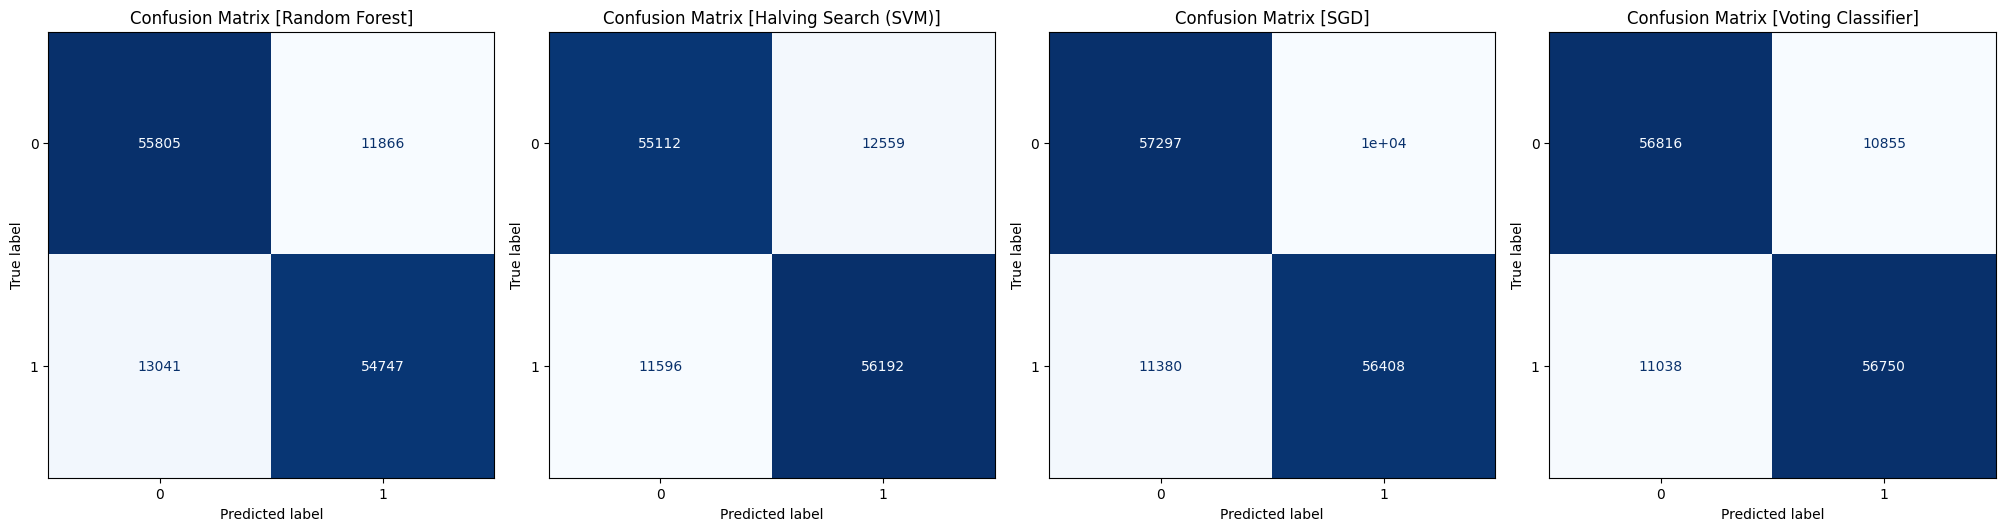

In [ ]:
models = {
    'Random Forest': rf_search,
    'Halving Search (SVM)': halving_search,
    'SGD': sgd_search,
    'Voting Classifier': eclf
}

# Create subplots
n_models = len(models)
fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 5), constrained_layout=True)

for ax, (model_name, model) in zip(axes, models.items()):
    # Confusion Matrix for each model
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
    ax.set_title(f'Confusion Matrix [{model_name}]')

plt.show()


1. **Model Dictionary**:
   - A dictionary named `models` stores four classifiers:
     - `Random Forest` (`rf_search`)
     - `Halving Search (SVM)` (`halving_search`)
     - `SGD` (`sgd_search`)
     - `Voting Classifier` (`eclf`)

2. **Subplots Creation**:
   - Creates a subplot grid with one row and four columns to display the confusion matrices of all classifiers side by side.

3. **Confusion Matrix Display**:
   - For each model:
     - Generates predictions (`y_pred`) using the test data (`X_test`).
     - Computes the confusion matrix using `confusion_matrix`.
     - Displays the confusion matrix using `ConfusionMatrixDisplay` with labels and a blue color map (`cmap=plt.cm.Blues`).
     - Sets the title of each subplot to indicate the corresponding model.

4. **Layout**:
   - The layout is optimized for clarity using `constrained_layout=True`.


#### **Confusion Matrix Interpretation**

The confusion matrices highlight the classification performance of the four models—Random Forest, SVM, SGD, and Voting Classifier. Here's the general interpretation:

1. **Random Forest**:
   - Balances well between true positives and true negatives.
   - Slightly higher false negatives suggest it sometimes fails to predict positive cases accurately.

2. **SVM (Halving Search)**:
   - Performs well overall but shows a moderate trade-off between false positives and false negatives.
   - This indicates a balanced but slightly less robust model compared to Random Forest.

3. **SGD**:
   - Achieves strong results, with a lower number of misclassifications.
   - Handles imbalanced data relatively well, showcasing its effectiveness for text-based or sparse features.

4. **Voting Classifier**:
   - Combines predictions from all models, achieving a good balance between precision and recall.
   - Slightly reduces errors compared to individual models, benefiting from ensemble learning.

#### General Insights:
- All models perform well with small differences in trade-offs between precision and recall.
- Ensemble methods (Voting Classifier) tend to provide slightly more robust results by leveraging the strengths of individual models.


# **Road Blocks**

1. Limitation on TF-IDF Features Due to Computational Constraints
We utilized TF-IDF (Term Frequency-Inverse Document Frequency) to vectorize text data. However, due to limited computational resources, we had to restrict the number of features extracted from the text. Ultimately, we selected 2000 features, which was a reasonable number for our model to train reliably. Using more features would have resulted in excessively long training times or memory overflow issues. This decision was a strategic trade-off to balance performance and efficiency.

2. Challenges with Sentiment Analysis Using BERT
We attempted sentiment analysis using the advanced NLP model BERT, but faced several challenges during the process.
First, the training time exceeded 20 hours, making the analysis process extremely slow. Additionally, the dataset size grew significantly, reaching over 10GB, which caused system memory shortages and frequent kernel crashes. Loading the dataset itself became a bottleneck, rendering the model training process infeasible and preventing us from leveraging the full potential of BERT.

Through these challenges, we learned the importance of selecting appropriate analytical methods and resource allocation strategies, considering both model complexity and dataset size.

# **Conclusion**

This project successfully developed and evaluated multiple machine learning models to classify Amazon product reviews as spam or not spam. By leveraging feature engineering techniques and combining numerical, categorical, and textual data, the models demonstrated high accuracy and reliability. The Random Forest, SGD, and SVM classifiers provided valuable insights into feature importance, showing that sentiment-based features and user feedback metrics played significant roles in predictions. The ensemble Voting Classifier effectively combined the strengths of individual models, achieving a balanced performance and reducing misclassification rates. Overall, the results support the practical application of these models in enhancing the authenticity of online reviews and maintaining consumer trust.


# **Gen AI Declaration**

We have used ChatGPT and Gemini for debugging and summarization purposes.